In [1]:
import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as mp
import matplotlib.colors as mc
import matplotlib.cm as cm
import scipy.ndimage
import matplotlib

import itertools
import random
import numpy.random
import scipy.stats
import os

import matplotlib.gridspec

mp.rcParams.update({'mathtext.default': 'regular'})

from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1

degree_sign = u'\u00B0'
% matplotlib inline

In [2]:
model_names = numpy.array(( \
'ACCESS1-0', \
'ACCESS1-3', \
'bcc-csm1-1-m', \
'bcc-csm1-1', \
'BNU-ESM', \
'CanESM2', \
'CCSM4', \
'CESM1-BGC', \
'CESM1-CAM5', \
'CMCC-CESM', \
'CMCC-CM', \
'CMCC-CMS', \
'CNRM-CM5', \
'CSIRO-Mk3-6-0', \
'EC-EARTH', \
'FGOALS-g2', \
'GFDL-CM3', \
'GFDL-ESM2G', \
'GFDL-ESM2M', \
'GISS-E2-H', \
'GISS-E2-R', \
'HadGEM2-AO', \
'HadGEM2-CC', \
'HadGEM2-ES', \
'inmcm4', \
'IPSL-CM5A-LR', \
'IPSL-CM5A-MR', \
'IPSL-CM5B-LR', \
'MIROC5', \
'MIROC-ESM-CHEM', \
'MIROC-ESM', \
'MPI-ESM-LR', \
'MPI-ESM-MR', \
'MRI-CGCM3', \
'NorESM1-ME', \
'NorESM1-M' ))
nmods = len(model_names)

In [3]:
pr_lat_lo, pr_lat_hi, pr_lon_lo, pr_lon_hi = 10., 70., 100., 350.; region = 'pr_CA'
ts_lat_lo, ts_lat_hi, ts_lon_lo, ts_lon_hi = -70., 70., 100., 350.; region = 'ts_tropacific'
ua_lat_lo, ua_lat_hi, ua_lon_lo, ua_lon_hi = -70., 70., 100., 350.; region = 'ua_midlatpacific'

season='djf'; SEASON='DJF'

In [4]:
pr_PLOT_lat_lo, pr_PLOT_lat_hi, pr_PLOT_lon_lo, pr_PLOT_lon_hi = 25., 65., 190., 270.
ts_PLOT_lat_lo, ts_PLOT_lat_hi, ts_PLOT_lon_lo, ts_PLOT_lon_hi = -45., 65., 120., 310.
ua_PLOT_lat_lo, ua_PLOT_lat_hi, ua_PLOT_lon_lo, ua_PLOT_lon_hi = 0., 65., 110., 280.

In [7]:
# OPEN TS DATASET
ncfile = Dataset('../../DATA/cmip5_data/ts/djf/NorESM1-M_ts_1980-10_climatology_djf.nc', 'r', format='NETCDF4')

ts_data_orig = ncfile.variables['ts'][:]
ts_lat = ncfile.variables['lat'][:]
ts_lon = ncfile.variables['lon'][:]

# pull out lat/lon indices
ts_lat_inds = numpy.where((ts_lat>=ts_lat_lo) & (ts_lat<=ts_lat_hi))[0]
ts_lon_inds = numpy.where((ts_lon>=ts_lon_lo) & (ts_lon<=ts_lon_hi))[0]
ts_regional_lat_vals = ts_lat[ts_lat_inds[0]:(ts_lat_inds[-1]+1)]
ts_regional_lon_vals = ts_lon[ts_lon_inds[0]:(ts_lon_inds[-1]+1)]    

ts_data = ts_data_orig[ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
ts_regional_nlat, ts_regional_nlon = ts_data.shape
global_nlat, global_nlon = ts_data_orig.shape[0:2]
global_lat_vals = ts_lat[:]
global_lon_vals = ts_lon[:]

In [8]:
# OPEN TS OBSERVATIONS
ncfile = Dataset('../../DATA/obs_data/ERSSTv4/obs_ERSSTv4_72x144_SST_1980-2010_climatology_'+season+'.nc', 'r', format='NETCDF4')
obs_field_ts = ncfile.variables['sst'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]+273.15

# OPEN PR OBSERVATIONS
ncfile = Dataset('../../DATA/obs_data/pr_gpcp/obs_GPCP_72x144_PRECT_1980-2010_climatology_'+season+'.nc', 'r', format='NETCDF4')
pr_lat = ncfile.variables['lat'][:]
pr_lon = ncfile.variables['lon'][:]
pr_lat_inds = numpy.where((pr_lat>=pr_lat_lo) & (pr_lat<=pr_lat_hi))[0]
pr_lon_inds = numpy.where((pr_lon>=pr_lon_lo) & (pr_lon<=pr_lon_hi))[0]
obs_field_pr = ncfile.variables['PRECT'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
pr_regional_nlat, pr_regional_nlon = obs_field_pr.shape

pr_regional_lat_vals = pr_lat[pr_lat_inds[0]:(pr_lat_inds[-1]+1)]
pr_regional_lon_vals = pr_lon[pr_lon_inds[0]:(pr_lon_inds[-1]+1)] 

# OPEN UA OBSERVATIONS
ncfile = Dataset('../../DATA/obs_data/u200_MERRA/obs_MERRA_2.5x2.5_u200_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
ua_lat = ncfile.variables['lat'][:]
ua_lon = ncfile.variables['lon'][:]
ua_lat_inds = numpy.where((ua_lat>=ua_lat_lo) & (ua_lat<=ua_lat_hi))[0]
ua_lon_inds = numpy.where((ua_lon>=ua_lon_lo) & (ua_lon<=ua_lon_hi))[0]
obs_field_ua = ncfile.variables['u200'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
ua_regional_nlat, ua_regional_nlon = obs_field_ua.shape

ua_regional_lat_vals = ua_lat[ua_lat_inds[0]:(ua_lat_inds[-1]+1)]
ua_regional_lon_vals = ua_lon[ua_lon_inds[0]:(ua_lon_inds[-1]+1)] 

In [11]:
# set up data
model_data_hist_pr = numpy.zeros((len(model_names), pr_regional_nlat, pr_regional_nlon))
model_data_eoc_pr = numpy.zeros((len(model_names), pr_regional_nlat, pr_regional_nlon))
model_data_hist_pr_LENS = numpy.zeros((30, pr_regional_nlat, pr_regional_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/pr/'+season+'/'+modelname+'_pr_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_pr[i,:,:] = ncfile.variables['pr'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/pr/'+season+'/'+modelname+'_pr_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_pr[i,:,:] = ncfile.variables['pr'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    ncfile.close()

for i in range(30): # 30 members in NCAR large ensemble
    # OPEN NCAR LARGE ENSEMBLE
    member_name = '{:02d}'.format(i+1)
    # get convective precipitation
    ncfile = Dataset('../../DATA/lens_data/PRECC/'+season+'/'+member_name + '_PRECC_1980-10_climatology_'+season+'_2.5x2.5regrid.nc', 'r', format='NETCDF4')
    precc_temp = ncfile.variables['PRECC'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    # get large-scale precipitation
    ncfile = Dataset('../../DATA/lens_data/PRECL/'+season+'/'+member_name + '_PRECL_1980-10_climatology_'+season+'_2.5x2.5regrid.nc', 'r', format='NETCDF4')
    precl_temp = ncfile.variables['PRECL'][pr_lat_inds[0]:(pr_lat_inds[-1]+1), pr_lon_inds[0]:(pr_lon_inds[-1]+1)]
    # add together
    model_data_hist_pr_LENS[i,:,:] = precc_temp + precl_temp

In [13]:
# IMPORT TS DATA
model_data_hist_ts = numpy.zeros((len(model_names), ts_regional_nlat, ts_regional_nlon))
model_data_eoc_ts = numpy.zeros((len(model_names), ts_regional_nlat, ts_regional_nlon))
model_data_hist_ts_LENS = numpy.zeros((30, ts_regional_nlat, ts_regional_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/ts/'+season+'/'+modelname+'_ts_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_ts[i,:,:] = ncfile.variables['ts'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/ts/'+season+'/'+modelname+'_ts_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_ts[i,:,:] = ncfile.variables['ts'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
    ncfile.close()

for i in range(30): # 30 members in NCAR large ensemble
    # OPEN NCAR LARGE ENSEMBLE
    member_name = '{:02d}'.format(i+1)
    #print(member_name)
    # get convective precipitation
    ncfile = Dataset('../../DATA/lens_data/TS/'+season+'/'+member_name + '_TS_1980-10_climatology_'+season+'_2.5x2.5regrid.nc', 'r', format='NETCDF4')
    model_data_hist_ts_LENS[i,:,:] = ncfile.variables['TS'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]    

In [14]:
# IMPORT UA200 DATA
model_data_hist_ua = numpy.zeros((len(model_names), ua_regional_nlat, ua_regional_nlon))
model_data_eoc_ua = numpy.zeros((len(model_names), ua_regional_nlat, ua_regional_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/ua200/'+season+'/'+modelname+'_ua200_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_ua[i,:,:] = ncfile.variables['ua'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/ua200/'+season+'/'+modelname+'_ua200_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_ua[i,:,:] = ncfile.variables['ua'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
    ncfile.close()

In [15]:
ncal_latlon = numpy.load('../../DATA/ncal_latlon_array.npy')
ccal_latlon = numpy.load('../../DATA/ccal_latlon_array.npy')
scal_latlon = numpy.load('../../DATA/scal_latlon_array.npy')

In [16]:
# precip indices
pr_indices_lon_ncal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, ncal_latlon[i,0]))[0][0] for i in range(ncal_latlon.shape[0]) ]
pr_indices_lat_ncal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, ncal_latlon[i,1]))[0][0] for i in range(ncal_latlon.shape[0]) ]

pr_indices_lon_ccal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, ccal_latlon[i,0]))[0][0] for i in range(ccal_latlon.shape[0]) ]
pr_indices_lat_ccal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, ccal_latlon[i,1]))[0][0] for i in range(ccal_latlon.shape[0]) ]

pr_indices_lon_scal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, scal_latlon[i,0]))[0][0] for i in range(scal_latlon.shape[0]) ]
pr_indices_lat_scal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, scal_latlon[i,1]))[0][0] for i in range(scal_latlon.shape[0]) ]

# take all data and ravel

In [17]:
# NOW TAKE ALL PR DATA AND RAVEL IT
# CALCULATE ENSEMBLE MEAN FOR EOC CONVERGENCE
model_field_mmem_pr = numpy.mean(model_data_eoc_pr, axis=0)
model_field_mmem_ts = numpy.mean(model_data_eoc_ts, axis=0)
model_field_mmem_ua = numpy.mean(model_data_eoc_ua, axis=0)

# NOW CALCULATE BIAS AND CONVERGENCE
bias_values_pr = numpy.zeros((nmods))
convergence_values_pr = numpy.zeros((nmods))

bias_values_ts = numpy.zeros((nmods))
convergence_values_ts = numpy.zeros((nmods))

bias_values_ua = numpy.zeros((nmods))
convergence_values_ua = numpy.zeros((nmods))

for i in range(nmods):
    hist_field_pr = model_data_hist_pr[i,:,:]
    eoc_field_pr = model_data_eoc_pr[i,:,:]
    
    hist_field_ts = model_data_hist_ts[i,:,:]
    eoc_field_ts = model_data_eoc_ts[i,:,:]

    hist_field_ua = model_data_hist_ua[i,:,:]
    eoc_field_ua = model_data_eoc_ua[i,:,:]

    bias_values_pr[i] = numpy.sqrt( numpy.mean((hist_field_pr - obs_field_pr)**2.) )
    convergence_values_pr[i] = numpy.sqrt( numpy.mean((eoc_field_pr - model_field_mmem_pr)**2.) )
    
    bias_values_ts[i] = numpy.sqrt( numpy.mean((hist_field_ts - obs_field_ts)**2.) )
    convergence_values_ts[i] = numpy.sqrt( numpy.mean((eoc_field_ts - model_field_mmem_ts)**2.) )
    
    bias_values_ua[i] = numpy.sqrt( numpy.mean((hist_field_ua - obs_field_ua)**2.) )
    convergence_values_ua[i] = numpy.sqrt( numpy.mean((eoc_field_ua - model_field_mmem_ua)**2.) )

mmem_bias_pr = numpy.sqrt( numpy.mean( (numpy.mean(model_data_hist_pr, axis=0) - obs_field_pr)**2. ))
mmem_bias_ts = numpy.sqrt( numpy.mean( (numpy.mean(model_data_hist_ts, axis=0) - obs_field_ts)**2. ))
mmem_bias_ua = numpy.sqrt( numpy.mean( (numpy.mean(model_data_hist_ua, axis=0) - obs_field_ua)**2. ))

bias_values_pr_LENS = numpy.zeros((30))
bias_values_ts_LENS = numpy.zeros((30))

for i in range(30):
    hist_field_pr = model_data_hist_pr_LENS[i,:,:]
    hist_field_ts = model_data_hist_ts_LENS[i,:,:]
    
    bias_values_pr_LENS[i] = numpy.sqrt( numpy.mean( (hist_field_pr - obs_field_pr)**2.) )
    bias_values_ts_LENS[i] = numpy.sqrt( numpy.mean( (hist_field_ts - obs_field_ts)**2.) )

In [18]:
# create dictionaries to be used below
dict_pr = {
'bias_values_mods':bias_values_pr,
'convergence_values_mods':convergence_values_pr,
'bias_values_LENS':bias_values_pr_LENS,
'mmem_bias':mmem_bias_pr,
'nlat':pr_regional_nlat,
'nlon':pr_regional_nlon,
'fields_hist_mods':model_data_hist_pr,
'fields_eoc_mods':model_data_eoc_pr,
'obs_field':obs_field_pr,
'LENS':True
}

dict_ts = {
'bias_values_mods':bias_values_ts,
'convergence_values_mods':convergence_values_ts,
'bias_values_LENS':bias_values_ts_LENS,
'mmem_bias':mmem_bias_ts,
'nlat':ts_regional_nlat,
'nlon':ts_regional_nlon,
'fields_hist_mods':model_data_hist_ts,
'fields_eoc_mods':model_data_eoc_ts,
'obs_field':obs_field_ts,
'LENS':True
}

dict_ua = {
'bias_values_mods':bias_values_ua,
'convergence_values_mods':convergence_values_ua,
'mmem_bias':mmem_bias_ua,
'LENS':False,
'nlat':ua_regional_nlat,
'nlon':ua_regional_nlon,
'fields_hist_mods':model_data_hist_ua,
'obs_field':obs_field_ua
}

In [20]:
cmap = cm.get_cmap('RdBu')
cmap_dict = cmap._segmentdata
cmap_dict.keys()

cmap_red, cmap_green, cmap_blue, cmap_alpha = cmap_dict['red'], cmap_dict['green'], cmap_dict['blue'], cmap_dict['alpha']
cmap_segment_subset = [0,1,2,3,7,8,9,10]
cmap_red = [cmap_red[idx] for idx in cmap_segment_subset]
cmap_green = [cmap_green[idx] for idx in cmap_segment_subset]
cmap_blue = [cmap_blue[idx] for idx in cmap_segment_subset]
cmap_alpha = [cmap_alpha[idx] for idx in cmap_segment_subset]
cmap_dict = {'red':cmap_red, 'blue':cmap_blue, 'green':cmap_green, 'alpha':cmap_alpha}

cmap_new = mc.LinearSegmentedColormap('cmap_new', cmap_dict)

# plot MMEM precipitation

# calculate individual ensemble indices for ncal, ccal, scal (precipitation)

In [21]:
dict_x=dict_pr
dict_y=dict_ts

# individual models
model_delta_pr_ncal = numpy.zeros(nmods)
model_delta_pr_ccal = numpy.zeros(nmods)
model_delta_pr_scal = numpy.zeros(nmods)

for i in range(nmods):
    hist = numpy.mean(dict_x['fields_hist_mods'][i,pr_indices_lat_ncal,pr_indices_lon_ncal])
    eoc = numpy.mean(dict_x['fields_eoc_mods'][i,pr_indices_lat_ncal,pr_indices_lon_ncal])
    model_delta_pr_ncal[i] = eoc-hist

    hist = numpy.mean(dict_x['fields_hist_mods'][i,pr_indices_lat_ccal,pr_indices_lon_ccal])
    eoc = numpy.mean(dict_x['fields_eoc_mods'][i,pr_indices_lat_ccal,pr_indices_lon_ccal])
    model_delta_pr_ccal[i] = eoc-hist

    hist = numpy.mean(dict_x['fields_hist_mods'][i,pr_indices_lat_scal,pr_indices_lon_scal])
    eoc = numpy.mean(dict_x['fields_eoc_mods'][i,pr_indices_lat_scal,pr_indices_lon_scal])
    model_delta_pr_scal[i] = eoc-hist

# calculate correlations (precipitation with precipitation)

In [22]:
# calculate all biases relative to obs
model_minus_obs_pr = numpy.zeros((nmods,pr_regional_nlat,pr_regional_nlon))

for i in range(nmods):
    model_minus_obs_pr[i,:,:] = dict_pr['fields_hist_mods'][i,:,:] - dict_pr['obs_field']

correlation_pvals_ncal = numpy.zeros((pr_regional_nlat, pr_regional_nlon))
correlation_map_ncal = numpy.zeros((pr_regional_nlat, pr_regional_nlon))

correlation_pvals_ccal = numpy.zeros((pr_regional_nlat, pr_regional_nlon))
correlation_map_ccal = numpy.zeros((pr_regional_nlat, pr_regional_nlon))

correlation_pvals_scal = numpy.zeros((pr_regional_nlat, pr_regional_nlon))
correlation_map_scal = numpy.zeros((pr_regional_nlat, pr_regional_nlon))

for j in range(pr_regional_nlat):
    for k in range(pr_regional_nlon):
        correlation_map_ncal[j,k], correlation_pvals_ncal[j,k] = scipy.stats.pearsonr(model_delta_pr_ncal, model_minus_obs_pr[:,j,k])
        correlation_map_ccal[j,k], correlation_pvals_ccal[j,k] = scipy.stats.pearsonr(model_delta_pr_ccal, model_minus_obs_pr[:,j,k])
        correlation_map_scal[j,k], correlation_pvals_scal[j,k] = scipy.stats.pearsonr(model_delta_pr_scal, model_minus_obs_pr[:,j,k])

# Calculate correlations (precipitation with SSTs)

In [23]:
# calculate all biases relative to obs

model_minus_obs_ts = numpy.zeros((nmods,ts_regional_nlat,ts_regional_nlon))

for i in range(nmods):
    model_minus_obs_ts[i,:,:] = dict_ts['fields_hist_mods'][i,:,:] - dict_ts['obs_field']

correlation_pvals_ncal = numpy.zeros((ts_regional_nlat, ts_regional_nlon))
correlation_map_ncal = numpy.zeros((ts_regional_nlat, ts_regional_nlon))

correlation_pvals_ccal = numpy.zeros((ts_regional_nlat, ts_regional_nlon))
correlation_map_ccal = numpy.zeros((ts_regional_nlat, ts_regional_nlon))

correlation_pvals_scal = numpy.zeros((ts_regional_nlat, ts_regional_nlon))
correlation_map_scal = numpy.zeros((ts_regional_nlat, ts_regional_nlon))

for j in range(ts_regional_nlat):
    for k in range(ts_regional_nlon):
        correlation_map_ncal[j,k], correlation_pvals_ncal[j,k] = scipy.stats.pearsonr(model_delta_pr_ncal, model_minus_obs_ts[:,j,k])
        correlation_map_ccal[j,k], correlation_pvals_ccal[j,k] = scipy.stats.pearsonr(model_delta_pr_ccal, model_minus_obs_ts[:,j,k])
        correlation_map_scal[j,k], correlation_pvals_scal[j,k] = scipy.stats.pearsonr(model_delta_pr_scal, model_minus_obs_ts[:,j,k])

0.5660292932782066


/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


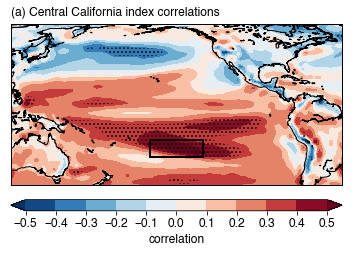

In [25]:
fontsize=12

fig = mp.figure(figsize=(5,5))
titles = ['Northern California index correlations', 'Central California index correlations', 'Southern California index correlations']
corr_maps_ts = [correlation_map_ncal, correlation_map_ccal, correlation_map_scal]
pval_maps_ts = [correlation_pvals_ncal, correlation_pvals_ccal, correlation_pvals_scal]

ax = fig.add_subplot(1,1,1)
    
i=1
    
print(corr_maps_ts[i].max())

ax.text(s='(a) ' + titles[i],x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)

map = basemap.Basemap(projection='cea',llcrnrlat=ts_PLOT_lat_lo,urcrnrlat=ts_PLOT_lat_hi,llcrnrlon=ts_PLOT_lon_lo,urcrnrlon=ts_PLOT_lon_hi,resolution='l',ax=ax)

map.drawcoastlines(linewidth=1, color='0.') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1, color='0.')

lons,lats = numpy.meshgrid(ts_regional_lon_vals, ts_regional_lat_vals)
xi,yi = map(lons, lats)
corr_map_smooth = scipy.ndimage.zoom(corr_maps_ts[i],2.5)
xi_smooth = scipy.ndimage.zoom(xi,2.5)
yi_smooth = scipy.ndimage.zoom(yi,2.5)

contour_levels = numpy.arange(-0.5,0.51,0.1)
pr_map = map.contourf(xi_smooth, yi_smooth, corr_map_smooth, levels=contour_levels, extend='both', cmap=cm.RdBu_r)
pval_map = map.contourf(xi, yi, pval_maps_ts[i], colors='None', levels=[0.0,0.05,1.0], hatches=['...', None], extend='lower')

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='7%', pad=0.2)
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label('correlation', fontsize=fontsize)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks(numpy.arange(-0.5,0.51,0.1))

fig.tight_layout(h_pad=1.75)

ts_corr_lat_lo, ts_corr_lat_hi, ts_corr_lon_lo, ts_corr_lon_hi = -25,-15,200.,230.

x1,y1 = map(ts_corr_lon_lo, ts_corr_lat_lo)
x2,y2 = map(ts_corr_lon_lo, ts_corr_lat_hi)
x3,y3 = map(ts_corr_lon_hi, ts_corr_lat_hi)
x4,y4 = map(ts_corr_lon_hi, ts_corr_lat_lo)
poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                  facecolor='None',edgecolor='0.',\
                                  linewidth=2,linestyle='-')
ax.add_patch(poly)

# Now do spatial averages and create scatter plots

# Import order of data according to legend from Figure 2

In [29]:
bias_sort = numpy.load('../../DATA/subensemble_data/bias_sort_indices.npy')
model_names_sorted = numpy.load('../../DATA/subensemble_data/model_names_sorted.npy')

In [30]:
print(model_names[bias_sort])

['EC-EARTH' 'HadGEM2-CC' 'HadGEM2-ES' 'HadGEM2-AO' 'CanESM2' 'CCSM4'
 'MIROC5' 'IPSL-CM5A-LR' 'ACCESS1-0' 'MPI-ESM-LR' 'CESM1-BGC' 'CNRM-CM5'
 'IPSL-CM5A-MR' 'CSIRO-Mk3-6-0' 'GFDL-ESM2G' 'CESM1-CAM5' 'GFDL-ESM2M'
 'NorESM1-M' 'NorESM1-ME' 'ACCESS1-3' 'CMCC-CM' 'inmcm4' 'CMCC-CESM'
 'CMCC-CMS' 'MPI-ESM-MR' 'GISS-E2-R' 'bcc-csm1-1' 'GISS-E2-H' 'GFDL-CM3'
 'bcc-csm1-1-m' 'MIROC-ESM-CHEM' 'MIROC-ESM' 'FGOALS-g2' 'BNU-ESM'
 'MRI-CGCM3' 'IPSL-CM5B-LR']


In [31]:
ncfile = Dataset('../../DATA/obs_data/ERSSTv4/obs_ERSSTv4_72x144_SST_1980-2010_climatology_'+season+'.nc', 'r', format='NETCDF4')
ts_lat = ncfile.variables['lat'][:]
ts_lon = ncfile.variables['lon'][:]
ts_lat_inds = numpy.where((ts_lat>=ts_corr_lat_lo) & (ts_lat<=ts_corr_lat_hi))[0]
ts_lon_inds = numpy.where((ts_lon>=ts_corr_lon_lo) & (ts_lon<=ts_corr_lon_hi))[0]
obs_field_ts = ncfile.variables['sst'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]+273.15
ts_index_nlat, ts_index_nlon = obs_field_ts.shape

ts_index_lat_vals = ts_lat[ts_lat_inds[0]:(ts_lat_inds[-1]+1)]
ts_index_lon_vals = ts_lon[ts_lon_inds[0]:(ts_lon_inds[-1]+1)] 

# IMPORT ts200 DATA
model_data_hist_ts = numpy.zeros((len(model_names), ts_index_nlat, ts_index_nlon))
model_data_eoc_ts = numpy.zeros((len(model_names), ts_index_nlat, ts_index_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/ts/'+season+'/'+modelname+'_ts_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_ts[i,:,:] = ncfile.variables['ts'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('../../DATA/cmip5_data/ts/'+season+'/'+modelname+'_ts_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_ts[i,:,:] = ncfile.variables['ts'][ts_lat_inds[0]:(ts_lat_inds[-1]+1), ts_lon_inds[0]:(ts_lon_inds[-1]+1)]
    ncfile.close()

In [32]:
# calculating bias in U200 index region
ts_index = numpy.zeros((36))
for i in range(nmods):
    ts_index[i] = numpy.mean(model_data_hist_ts[i,:,:])

# Calculate correlations (precipitation with U-winds in domain)

In [33]:
# calculate all biases relative to obs
model_minus_obs_ua = numpy.zeros((nmods,ua_regional_nlat,ua_regional_nlon))

for i in range(nmods):
    model_minus_obs_ua[i,:,:] = dict_ua['fields_hist_mods'][i,:,:] - dict_ua['obs_field']

correlation_pvals_ncal = numpy.zeros((ua_regional_nlat, ua_regional_nlon))
correlation_map_ncal = numpy.zeros((ua_regional_nlat, ua_regional_nlon))

correlation_pvals_ccal = numpy.zeros((ua_regional_nlat, ua_regional_nlon))
correlation_map_ccal = numpy.zeros((ua_regional_nlat, ua_regional_nlon))

correlation_pvals_scal = numpy.zeros((ua_regional_nlat, ua_regional_nlon))
correlation_map_scal = numpy.zeros((ua_regional_nlat, ua_regional_nlon))

for j in range(ua_regional_nlat):
    for k in range(ua_regional_nlon):
        correlation_map_ncal[j,k], correlation_pvals_ncal[j,k] = scipy.stats.pearsonr(model_delta_pr_ncal, model_minus_obs_ua[:,j,k])
        correlation_map_ccal[j,k], correlation_pvals_ccal[j,k] = scipy.stats.pearsonr(model_delta_pr_ccal, model_minus_obs_ua[:,j,k])
        correlation_map_scal[j,k], correlation_pvals_scal[j,k] = scipy.stats.pearsonr(model_delta_pr_scal, model_minus_obs_ua[:,j,k])

0.5270346758232983
-0.5709104744624871


/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


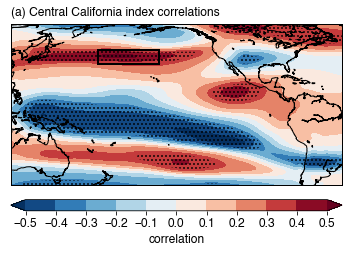

In [34]:
fontsize=12

fig = mp.figure(figsize=(5,5))
titles = ['Northern California index correlations', 'Central California index correlations', 'Southern California index correlations']
corr_maps_ua = [correlation_map_ncal, correlation_map_ccal, correlation_map_scal]
pval_maps_ua = [correlation_pvals_ncal, correlation_pvals_ccal, correlation_pvals_scal]
scatter_points_lon = [pr_indices_lon_ncal, pr_indices_lon_ccal, pr_indices_lon_scal]
scatter_points_lat = [pr_indices_lat_ncal, pr_indices_lat_ccal, pr_indices_lat_scal]

ax = fig.add_subplot(1,1,1)
    
i=1
    
print(corr_maps_ua[i].max())
print(corr_maps_ua[i].min())

ax.text(s='(a) ' + titles[i],x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)

map = basemap.Basemap(projection='cea',llcrnrlat=ts_PLOT_lat_lo,urcrnrlat=ts_PLOT_lat_hi,llcrnrlon=ts_PLOT_lon_lo,urcrnrlon=ts_PLOT_lon_hi,resolution='l',ax=ax)

map.drawcoastlines(linewidth=1, color='0.') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1, color='0.')

lons,lats = numpy.meshgrid(ua_regional_lon_vals, ua_regional_lat_vals)
xi,yi = map(lons, lats)
corr_map_smooth = scipy.ndimage.zoom(corr_maps_ua[i],2.5)
xi_smooth = scipy.ndimage.zoom(xi,2.5)
yi_smooth = scipy.ndimage.zoom(yi,2.5)

contour_levels = numpy.arange(-0.5,0.51,0.1)
pr_map = map.contourf(xi_smooth, yi_smooth, corr_map_smooth, levels=contour_levels, extend='both', cmap=cm.RdBu_r)
pval_map = map.contourf(xi, yi, pval_maps_ua[i], colors='None', levels=[0.0,0.05,1.0], hatches=['...', None], extend='lower')

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='7%', pad=0.2)
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label('correlation', fontsize=fontsize)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_ticks(numpy.arange(-0.5,0.51,0.1))

fig.tight_layout(h_pad=1.75)

ua_corr_lat_lo, ua_corr_lat_hi, ua_corr_lon_lo, ua_corr_lon_hi = 30,40,170.,205.

x1,y1 = map(ua_corr_lon_lo, ua_corr_lat_lo)
x2,y2 = map(ua_corr_lon_lo, ua_corr_lat_hi)
x3,y3 = map(ua_corr_lon_hi, ua_corr_lat_hi)
x4,y4 = map(ua_corr_lon_hi, ua_corr_lat_lo)
poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                  facecolor='None',edgecolor='0.',\
                                  linewidth=2,linestyle='-')
ax.add_patch(poly)

In [35]:
# collect u200 in the correlation index box
# OPEN UA OBSERVATIONS
ncfile = Dataset('/Users/baird/Dropbox/_data_analyzed/obs_calculations/u200_MERRA/obs_MERRA_2.5x2.5_u200_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
ua_lat = ncfile.variables['lat'][:]
ua_lon = ncfile.variables['lon'][:]
ua_lat_inds = numpy.where((ua_lat>=ua_corr_lat_lo) & (ua_lat<=ua_corr_lat_hi))[0]
ua_lon_inds = numpy.where((ua_lon>=ua_corr_lon_lo) & (ua_lon<=ua_corr_lon_hi))[0]
obs_field_ua = ncfile.variables['u200'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
ua_index_nlat, ua_index_nlon = obs_field_ua.shape

ua_index_lat_vals = ua_lat[ua_lat_inds[0]:(ua_lat_inds[-1]+1)]
ua_index_lon_vals = ua_lon[ua_lon_inds[0]:(ua_lon_inds[-1]+1)] 

# IMPORT UA200 DATA
model_data_hist_ua = numpy.zeros((len(model_names), ua_index_nlat, ua_index_nlon))
model_data_eoc_ua = numpy.zeros((len(model_names), ua_index_nlat, ua_index_nlon))

for i in range(nmods):
    #print("opening model", model_names[i])
    modelname = model_names[i]
    # OPEN HISTORICAL FIELDS
    ncfile = Dataset('/Users/baird/Dropbox/_data_analyzed/cmip5_calculations/ua200/'+season+'/'+modelname+'_ua200_1980-10_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_hist_ua[i,:,:] = ncfile.variables['ua'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
    ncfile.close()
    # OPEN FUTURE CHANGE FIELDS
    ncfile = Dataset('/Users/baird/Dropbox/_data_analyzed/cmip5_calculations/ua200/'+season+'/'+modelname+'_ua200_2070-99_climatology_'+season+'.nc', 'r', format='NETCDF4')
    model_data_eoc_ua[i,:,:] = ncfile.variables['ua'][ua_lat_inds[0]:(ua_lat_inds[-1]+1), ua_lon_inds[0]:(ua_lon_inds[-1]+1)]
    ncfile.close()

In [36]:
# calculating bias in U200 index region
u200_index = numpy.zeros((36))
for i in range(nmods):
    u200_index[i] = numpy.mean(model_data_hist_ua[i,:,:])

# Get index data from another file

In [52]:
plot_dict = numpy.load('../../DATA/subensemble_data/index_domain_info_k1to5_emergent_constraint_domains.npy')

In [53]:
model_delta_pr_ncal = plot_dict[()]['model_delta_pr_ncal']
model_delta_pr_ccal = plot_dict[()]['model_delta_pr_ccal']
model_delta_pr_scal = plot_dict[()]['model_delta_pr_scal']

subensembles_delta_pr_ncal = plot_dict[()]['subensembles_delta_pr_ncal']
subensembles_delta_pr_ccal = plot_dict[()]['subensembles_delta_pr_ccal']
subensembles_delta_pr_scal = plot_dict[()]['subensembles_delta_pr_scal']

optimal_subensembles_delta_pr_ncal = plot_dict[()]['optimal_subensembles_delta_pr_ncal']
optimal_subensembles_delta_pr_ccal = plot_dict[()]['optimal_subensembles_delta_pr_ccal']
optimal_subensembles_delta_pr_scal = plot_dict[()]['optimal_subensembles_delta_pr_scal']

ncal_fraction_all = plot_dict[()]['ncal_fraction_all']
ccal_fraction_all = plot_dict[()]['ccal_fraction_all']
scal_fraction_all = plot_dict[()]['scal_fraction_all']

ncal_fraction_po = plot_dict[()]['ncal_fraction_po']
ccal_fraction_po = plot_dict[()]['ccal_fraction_po']
scal_fraction_po = plot_dict[()]['scal_fraction_po']

N_ens = plot_dict[()]['N_ens']
optimal_subensembles = plot_dict[()]['optimal_subensembles']

## join all plots on single panel

In [54]:
ts_stderr = 0.0489429589043
u200_stderr = 0.999562414304

/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/baird/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


0.0008598768841827886
0.0010404840384325984
0.0015634526102009298
0.00978586324772774


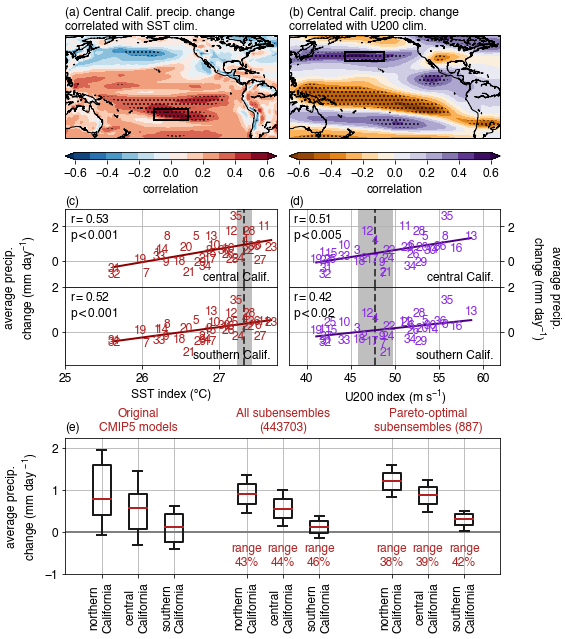

In [55]:
fontsize=12

fig = mp.figure(figsize=(7,8))

gs0 = matplotlib.gridspec.GridSpec(3,1, height_ratios=[2, 2.5, 1.75], width_ratios=[8])
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(3,6, subplot_spec=gs0[0])#, hspace=0, wspace=0)

####################################################################################################
####################################################################################################
####################################################################################################
# plot SST map
ax = mp.subplot(gs1[0:3,0:3])

titles = ['', 'Central Calif. precip. change\ncorrelated with SST clim.', '']
corr_maps = [correlation_map_ncal, correlation_map_ccal, correlation_map_scal]
pval_maps = [correlation_pvals_ncal, correlation_pvals_ccal, correlation_pvals_scal]
scatter_points_lon = [pr_indices_lon_ncal, pr_indices_lon_ccal, pr_indices_lon_scal]
scatter_points_lat = [pr_indices_lat_ncal, pr_indices_lat_ccal, pr_indices_lat_scal]  
i=1
ax.text(s='(a) ' + titles[i],x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)
map = basemap.Basemap(projection='cea',llcrnrlat=ts_PLOT_lat_lo,urcrnrlat=ts_PLOT_lat_hi,llcrnrlon=ts_PLOT_lon_lo,urcrnrlon=ts_PLOT_lon_hi,resolution='l',ax=ax)
map.drawcoastlines(linewidth=1, color='0.') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1, color='0.')
lons,lats = numpy.meshgrid(ts_regional_lon_vals, ts_regional_lat_vals)
xi,yi = map(lons, lats)
corr_map_smooth = scipy.ndimage.zoom(corr_maps_ts[i],2.5)
xi_smooth = scipy.ndimage.zoom(xi,2.5)
yi_smooth = scipy.ndimage.zoom(yi,2.5)
contour_levels = numpy.arange(-0.6,0.61,0.1)
pr_map = map.contourf(xi_smooth, yi_smooth, corr_map_smooth, levels=contour_levels, extend='both', cmap=cm.RdBu_r)
pval_map = map.contourf(xi, yi, pval_maps_ts[i], colors='None', levels=[0.0,0.05,1.0], hatches=['...', None], extend='lower')

ts_corr_lat_lo, ts_corr_lat_hi, ts_corr_lon_lo, ts_corr_lon_hi = -25,-15,200.,230.
x1,y1 = map(ts_corr_lon_lo, ts_corr_lat_lo)
x2,y2 = map(ts_corr_lon_lo, ts_corr_lat_hi)
x3,y3 = map(ts_corr_lon_hi, ts_corr_lat_hi)
x4,y4 = map(ts_corr_lon_hi, ts_corr_lat_lo)
poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                  facecolor='None',edgecolor='0.',\
                                  linewidth=2,linestyle='-')
ax.add_patch(poly)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='7%', pad=0.2)
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label('correlation', fontsize=fontsize)
cbar_ax.tick_params(labelsize=fontsize)


####################################################################################################
####################################################################################################
####################################################################################################
# plot U200 map
ax = mp.subplot(gs1[0:3,3:6])

titles = ['', 'Central Calif. precip. change\ncorrelated with U200 clim.', '']
corr_maps_ua = [correlation_map_ncal, correlation_map_ccal, correlation_map_scal]
pval_maps_ua = [correlation_pvals_ncal, correlation_pvals_ccal, correlation_pvals_scal]
scatter_points_lon = [pr_indices_lon_ncal, pr_indices_lon_ccal, pr_indices_lon_scal]
scatter_points_lat = [pr_indices_lat_ncal, pr_indices_lat_ccal, pr_indices_lat_scal]
i=1
ax.text(s='(b) ' + titles[i],x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)
map = basemap.Basemap(projection='cea',llcrnrlat=ts_PLOT_lat_lo,urcrnrlat=ts_PLOT_lat_hi,llcrnrlon=ts_PLOT_lon_lo,urcrnrlon=ts_PLOT_lon_hi,resolution='l',ax=ax)
map.drawcoastlines(linewidth=1, color='0.') # you can specify white as 1.0, black as 0.0, and any gray as fraction
map.drawmapboundary(linewidth=1, color='0.')
lons,lats = numpy.meshgrid(ua_regional_lon_vals, ua_regional_lat_vals)
xi,yi = map(lons, lats)
corr_map_smooth = scipy.ndimage.zoom(corr_maps_ua[i],2.5)
xi_smooth = scipy.ndimage.zoom(xi,2.5)
yi_smooth = scipy.ndimage.zoom(yi,2.5)
contour_levels = numpy.arange(-0.6,0.61,0.1)
pr_map = map.contourf(xi_smooth, yi_smooth, corr_map_smooth, levels=contour_levels, extend='both', cmap=cm.PuOr)
pval_map = map.contourf(xi, yi, pval_maps_ua[i], colors='None', levels=[0.0,0.05,1.0], hatches=['...', None], extend='lower')

ua_corr_lat_lo, ua_corr_lat_hi, ua_corr_lon_lo, ua_corr_lon_hi = 30,40,170.,205.
x1,y1 = map(ua_corr_lon_lo, ua_corr_lat_lo)
x2,y2 = map(ua_corr_lon_lo, ua_corr_lat_hi)
x3,y3 = map(ua_corr_lon_hi, ua_corr_lat_hi)
x4,y4 = map(ua_corr_lon_hi, ua_corr_lat_lo)
poly = matplotlib.patches.Polygon([(x1,y1),(x2,y2),(x3,y3),(x4,y4)],\
                                  facecolor='None',edgecolor='0.',\
                                  linewidth=2,linestyle='-')
ax.add_patch(poly)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='7%', pad=0.2)
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label('correlation', fontsize=fontsize)
cbar_ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(numpy.arange(-0.5,0.51,0.1))

####################################################################################################
####################################################################################################
####################################################################################################
# plot correlation values for TS
gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(5,6, subplot_spec=gs0[1], hspace=0)

ax1 = mp.subplot(gs2[0:2,0:3])

ax1.text(s='(c)', x=0, y=1.03, transform=ax1.transAxes, ha='left', va='bottom', fontsize=fontsize)
for i in range(nmods):
    ax1.text(s=str(i+1),\
             x=ts_index[bias_sort[i]]-273.15,\
             y=model_delta_pr_ccal[bias_sort[i]],\
             ha='center',va='center',\
             weight='normal',color='firebrick',\
             fontsize=fontsize)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

# LINEAR REGRESSION LINE
slope, intercept, blah, blah, blah = scipy.stats.linregress(ts_index-273.15, model_delta_pr_ccal)
xvals = numpy.linspace(ts_index.min()-273.15, ts_index.max()-273.15, 1000)
yvals = slope*xvals + intercept
ax1.plot(xvals, yvals, lw=2, zorder=1, color='darkred')

ax1.tick_params(labelsize=fontsize)
ax1.yaxis.tick_left()
ax1.set_xlim(24.5,27.75)
ax1.set_ylim(-1.5,3)
ax1.axvspan(obs_field_ts.mean()-273.15-1.96*ts_stderr, obs_field_ts.mean()-273.15+1.96*ts_stderr, color='0.75', zorder=0)
ax1.axvline(x=obs_field_ts.mean()-273.15, lw=2, ls='--', c='0.25', zorder=0)
ax1.grid()
ax1.set_axisbelow(True)
rval,pval = scipy.stats.pearsonr(ts_index, model_delta_pr_ccal)
print(pval)
ax1.text(s='$r=$'+'{:.2f}'.format(rval)+'\n'+'$p<$'+'0.001', x=0.02, y=0.94, ha='left', va='top', transform=ax1.transAxes, fontsize=fontsize)
ax1.text(s='central Calif.', x=0.97, y=0.05, ha='right', va='bottom', transform=ax1.transAxes, fontsize=fontsize)

ax2 = mp.subplot(gs2[2:4,0:3], sharex=ax1)
for i in range(nmods):
    ax2.text(s=str(i+1),\
             x=ts_index[bias_sort][i]-273.15,\
             y=model_delta_pr_scal[bias_sort][i],\
             ha='center',va='center',\
             weight='normal',color='firebrick',\
             fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax2.yaxis.tick_left()
ax2.set_xlim(25,27.75)
ax2.set_ylim(-1.5,2)

# LINEAR REGRESSION LINE
slope, intercept, blah, blah, blah = scipy.stats.linregress(ts_index-273.15, model_delta_pr_scal)
xvals = numpy.linspace(ts_index.min()-273.15, ts_index.max()-273.15, 1000)
yvals = slope*xvals + intercept
ax2.plot(xvals, yvals, lw=2, zorder=1, color='darkred')
ax2.set_xlabel('SST index ('+degree_sign+'C)', fontsize=fontsize)
ax2.text(s='average precip.\nchange (mm day$^{-1}$)', x=-0.2, y=1.0, rotation=90, ha='center', va='center', fontsize=fontsize, transform=ax2.transAxes)

ax2.axvspan(obs_field_ts.mean()-273.15-1.96*ts_stderr, obs_field_ts.mean()-273.15+1.96*ts_stderr, color='0.75', zorder=0)
ax2.axvline(x=obs_field_ts.mean()-273.15, lw=2, ls='--', c='0.25', zorder=0)
rval,pval = scipy.stats.pearsonr(ts_index, model_delta_pr_scal)
ax2.text(s='$r=$'+'{:.2f}'.format(rval)+'\n'+'$p<$'+'0.001', x=0.02, y=0.94, ha='left', va='top', transform=ax2.transAxes, fontsize=fontsize)
ax2.text(s='southern Calif.', x=0.97, y=0.05, ha='right', va='bottom', transform=ax2.transAxes, fontsize=fontsize, zorder=1)
print(pval)
ax2.grid()
ax2.set_axisbelow(True)


####################################################################################################
####################################################################################################
####################################################################################################
# plot correlation values for U200

ax1 = mp.subplot(gs2[0:2,3:6])

ax1.text(s='(d)', x=0, y=1.03, transform=ax1.transAxes, ha='left', va='bottom', fontsize=fontsize)
for i in range(nmods):
    ax1.text(s=str(i+1),\
             x=u200_index[bias_sort[i]],\
             y=model_delta_pr_ccal[bias_sort[i]],\
             ha='center',va='center',\
             weight='normal',color='blueviolet',\
             fontsize=fontsize)

# LINEAR REGRESSION LINE
slope, intercept, blah, blah, blah = scipy.stats.linregress(u200_index, model_delta_pr_ccal)
xvals = numpy.linspace(u200_index.min(), u200_index.max(), 1000)
yvals = slope*xvals + intercept
ax1.plot(xvals, yvals, lw=2, zorder=1, color='indigo')

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
ax1.yaxis.tick_right()
ax1.tick_params(labelsize=fontsize)
ax1.set_xlim(38,62)
ax1.set_ylim(-1.5,3)
ax1.axvspan(obs_field_ua.mean()-1.96*u200_stderr, obs_field_ua.mean()+1.96*u200_stderr, color='0.75', zorder=0)
ax1.axvline(x=obs_field_ua.mean(), lw=2, ls='--', c='0.25', zorder=0)
ax1.grid()
ax1.set_axisbelow(True)
rval,pval = scipy.stats.pearsonr(u200_index, model_delta_pr_ccal)
print(pval)
ax1.text(s='$r=$'+'{:.2f}'.format(rval)+'\n'+'$p<$'+'0.005', x=0.02, y=0.94, ha='left', va='top', transform=ax1.transAxes, fontsize=fontsize)
ax1.text(s='central Calif.', x=0.97, y=0.05, ha='right', va='bottom', transform=ax1.transAxes, fontsize=fontsize)

ax2 = mp.subplot(gs2[2:4,3:6], sharex=ax1)
for i in range(nmods):
    ax2.text(s=str(i+1), \
             x=u200_index[bias_sort][i],\
             y=model_delta_pr_scal[bias_sort][i],\
             ha='center',va='center',\
             weight='normal',color='blueviolet',\
             fontsize=fontsize)

# LINEAR REGRESSION LINE
slope, intercept, blah, blah, blah = scipy.stats.linregress(u200_index, model_delta_pr_scal)
xvals = numpy.linspace(u200_index.min(), u200_index.max(), 1000)
yvals = slope*xvals + intercept
ax2.plot(xvals, yvals, lw=2, zorder=1, color='indigo')

ax2.tick_params(labelsize=fontsize)
ax2.yaxis.tick_right()
ax2.set_xlim(38,62)
ax2.set_ylim(-1.5,2)
ax2.set_xlabel('U200 index (m s$^{-1}$)', fontsize=fontsize)
ax2.text(s='average precip.\nchange (mm day$^{-1}$)', x=1.2, y=1.0, rotation=270, ha='center', va='center', fontsize=fontsize, transform=ax2.transAxes)
ax2.axvspan(obs_field_ua.mean()-1.96*u200_stderr, obs_field_ua.mean()+1.96*u200_stderr, color='0.75', zorder=0)
ax2.axvline(x=obs_field_ua.mean(), lw=2, ls='--', c='0.25', zorder=0)
rval,pval = scipy.stats.pearsonr(u200_index, model_delta_pr_scal)
ax2.text(s='$r=$'+'{:.2f}'.format(rval)+'\n'+'$p<$'+'0.02', x=0.02, y=0.94, ha='left', va='top', transform=ax2.transAxes, fontsize=fontsize)
ax2.text(s='southern Calif.', x=0.97, y=0.05, ha='right', va='bottom', transform=ax2.transAxes, fontsize=fontsize)
print(pval)
ax2.grid()
ax2.set_axisbelow(True)

####################################################################################################
####################################################################################################
####################################################################################################
# plot ranges

fig.tight_layout(h_pad=0)

gs3 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,6, subplot_spec=gs0[2])

lo_perc = 10
hi_perc = 90

ax = mp.subplot(gs3[:,:])
ax.text(s='(e)',x=0.0,y=1.03,ha='left',va='bottom',transform=ax.transAxes,fontsize=fontsize)
ax.axhline(0,lw=2,c='0.5', zorder=1)
boxplot_width=[0.5]
flierprops = dict(marker='.', markeredgecolor='0.1', markerfacecolor='0.1')
medianprops = dict(linewidth=2, color='firebrick')
boxprops = dict(linewidth=2, color='0.1')
whiskerprops = dict(linewidth=2, color='0.1')
capprops = dict(linewidth=2, color='0.1')
whisk_range = [lo_perc, hi_perc]
#whisk_range = 'range'
ax.boxplot(model_delta_pr_ncal, zorder=2, positions=[1.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.boxplot(model_delta_pr_ccal, zorder=2, positions=[2.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.boxplot(model_delta_pr_scal, zorder=2, positions=[3.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.text(s='Original\nCMIP5 models', x=2.0, y=2.35, fontsize=fontsize, ha='center', va='bottom', color='firebrick')
flierprops = dict(marker='.', markeredgecolor='0.1', markerfacecolor='0.1')
medianprops = dict(linewidth=2, color='firebrick')
boxprops = dict(linewidth=2, color='0.1')
whiskerprops = dict(linewidth=2, color='0.1')
capprops = dict(linewidth=2, color='0.1')
ax.boxplot(subensembles_delta_pr_ncal, zorder=2, positions=[5.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.boxplot(subensembles_delta_pr_ccal, zorder=2, positions=[6.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.boxplot(subensembles_delta_pr_scal, zorder=2, positions=[7.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.text(s='All subensembles\n('+str(N_ens)+')', x=6.0, y=2.35, fontsize=fontsize, ha='center', va='bottom', color='firebrick')
flierprops = dict(marker='+', s=1e-5, markeredgecolor='0.1', markerfacecolor='0.1')
medianprops = dict(linewidth=2, color='firebrick')
boxprops = dict(linewidth=2, color='0.1')
whiskerprops = dict(linewidth=2, color='0.1')
capprops = dict(linewidth=2, color='0.1')
ax.boxplot(optimal_subensembles_delta_pr_ncal, zorder=2, positions=[9.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.boxplot(optimal_subensembles_delta_pr_ccal, zorder=2, positions=[10.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
ax.boxplot(optimal_subensembles_delta_pr_scal, zorder=2, positions=[11.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)

cmip5_hi_val = numpy.percentile(model_delta_pr_ncal, hi_perc)
cmip5_lo_val = numpy.percentile(model_delta_pr_ncal, lo_perc)
hi_val = numpy.percentile(subensembles_delta_pr_ncal, hi_perc)
lo_val = numpy.percentile(subensembles_delta_pr_ncal, lo_perc)
ncal_fraction_all = (hi_val-lo_val)/(cmip5_hi_val-cmip5_lo_val) * 100.

cmip5_hi_val = numpy.percentile(model_delta_pr_ccal, hi_perc)
cmip5_lo_val = numpy.percentile(model_delta_pr_ccal, lo_perc)
hi_val = numpy.percentile(subensembles_delta_pr_ccal, hi_perc)
lo_val = numpy.percentile(subensembles_delta_pr_ccal, lo_perc)
ccal_fraction_all = (hi_val-lo_val)/(cmip5_hi_val-cmip5_lo_val) * 100.

cmip5_hi_val = numpy.percentile(model_delta_pr_scal, hi_perc)
cmip5_lo_val = numpy.percentile(model_delta_pr_scal, lo_perc)
hi_val = numpy.percentile(subensembles_delta_pr_scal, hi_perc)
lo_val = numpy.percentile(subensembles_delta_pr_scal, lo_perc)
scal_fraction_all = (hi_val-lo_val)/(cmip5_hi_val-cmip5_lo_val) * 100.

cmip5_hi_val = numpy.percentile(model_delta_pr_ncal, hi_perc)
cmip5_lo_val = numpy.percentile(model_delta_pr_ncal, lo_perc)
hi_val = numpy.percentile(optimal_subensembles_delta_pr_ncal, hi_perc)
lo_val = numpy.percentile(optimal_subensembles_delta_pr_ncal, lo_perc)
ncal_fraction_po = (hi_val-lo_val)/(cmip5_hi_val-cmip5_lo_val) * 100.

cmip5_hi_val = numpy.percentile(model_delta_pr_ccal, hi_perc)
cmip5_lo_val = numpy.percentile(model_delta_pr_ccal, lo_perc)
hi_val = numpy.percentile(optimal_subensembles_delta_pr_ccal, hi_perc)
lo_val = numpy.percentile(optimal_subensembles_delta_pr_ccal, lo_perc)
ccal_fraction_po = (hi_val-lo_val)/(cmip5_hi_val-cmip5_lo_val) * 100.

cmip5_hi_val = numpy.percentile(model_delta_pr_scal, hi_perc)
cmip5_lo_val = numpy.percentile(model_delta_pr_scal, lo_perc)
hi_val = numpy.percentile(optimal_subensembles_delta_pr_scal, hi_perc)
lo_val = numpy.percentile(optimal_subensembles_delta_pr_scal, lo_perc)
scal_fraction_po = (hi_val-lo_val)/(cmip5_hi_val-cmip5_lo_val) * 100.

ax.text(s='range\n'+'{:.0f}'.format(ncal_fraction_all)+'%', x=5.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax.text(s='range\n'+'{:.0f}'.format(ccal_fraction_all)+'%', x=6.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax.text(s='range\n'+'{:.0f}'.format(scal_fraction_all)+'%', x=7.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax.text(s='range\n'+'{:.0f}'.format(ncal_fraction_po)+'%', x=9.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax.text(s='range\n'+'{:.0f}'.format(ccal_fraction_po)+'%', x=10.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax.text(s='range\n'+'{:.0f}'.format(scal_fraction_po)+'%', x=11.0, y=-0.25, fontsize=fontsize, ha='center', va='top', color='firebrick')
ax.text(s='Pareto-optimal\nsubensembles ('+str(len(optimal_subensembles))+')', x=10.0, y=2.35, fontsize=fontsize, ha='center', va='bottom', color='firebrick')

ax.set_xlim(0,12)
ax.set_ylim(-1,2.25)
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('average precip.\nchange (mm day$^{\, -1}$)', fontsize=fontsize)
ax.set_xticklabels(['northern\nCalifornia', 'central\nCalifornia', 'southern\nCalifornia']*3, rotation=90, ha='center', va='top')
ax.set_xticks([1,2,3,5,6,7,9,10,11])
ax.grid()
ax.set_axisbelow(True)

fig.savefig('figure4_panel_plot_k1to5.pdf', bbox_inches='tight', transparent=True)